In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

import ncar_jobqueue
from dask.distributed import Client

Note: this notebook uses means over the 5th IAF cycle.

These means were made using this notebook:
/glade/u/home/kristenk/besome/alk_calc_paper/make_5th_IAF_mean.ipynb

### get CaCO3 burial control and noGCB

In [2]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'

In [4]:
#get calcToSed
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_calcToSed.nc'
cesm_ann_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [5]:
#get calcToSed_ALT_CO2
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_calcToSed_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['calcToSed_noGCB']=ds_tmp['calcToSed_ALT_CO2']

### get Alk with 2x GCB

In [6]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'

In [7]:
#get calcToSed_ALT_CO2
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_calcToSed_ALT_CO2.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['calcToSed_2xGCB']=ds_tmp['calcToSed_ALT_CO2']

### Now DS has everything we need

In [32]:
cesm_ann_ds.calcToSed

<xarray.DataArray 'calcToSed' (nlat: 384, nlon: 320)>
[122880 values with dtype=float32]
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     CaCO3 Flux to Sediments
    units:         nmol/cm^2/s
    grid_loc:      2110
    cell_methods:  time: mean
    coordinates:   TLONG TLAT

In [9]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = cesm_ann_ds.z_t

In [10]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
area_m=ds_woa.TAREA * 1e-4
depths_m=ds_woa.z_t * 0.01
dz=ds_woa.dz
dz_m=ds_woa.dz * 0.01

### look at calcToSed vars south of 30°S

In [12]:
cesm_ann_ds.calcToSed_noGCB.units

'nmol/cm^2/s'

In [20]:
convert = 86400. * 1.e-9 * 1.e3 * 1.e4

In [13]:
calc2sed_noGCB= esmlab.weighted_mean(cesm_ann_ds.calcToSed_noGCB.where(lats<-30), weights=area_m, dim=['nlat', 'nlon']).compute()
calc2sed_noGCB = calc2sed_noGCB.values * convert #converting to mmol/m2/day
calc2sed_noGCB

0.1193938621891784

In [14]:
calc2sed_control= esmlab.weighted_mean(cesm_ann_ds.calcToSed.where(lats<-30), weights=area_m, dim=['nlat', 'nlon']).compute()
calc2sed_control = calc2sed_control.values * convert #converting to mmol/m2/day
calc2sed_control

0.12751060847565807

In [15]:
calc2sed_2xGCB= esmlab.weighted_mean(cesm_ann_ds.calcToSed_2xGCB.where(lats<-30), weights=area_m, dim=['nlat', 'nlon']).compute()
calc2sed_2xGCB = calc2sed_2xGCB.values * convert #converting to mmol/m2/day
calc2sed_2xGCB

0.14592555534054485

In [18]:
calc2seds = [calc2sed_noGCB,calc2sed_control,calc2sed_2xGCB]
labels = ['noGCB','control','2xGCB']
positions = [1,2,3]

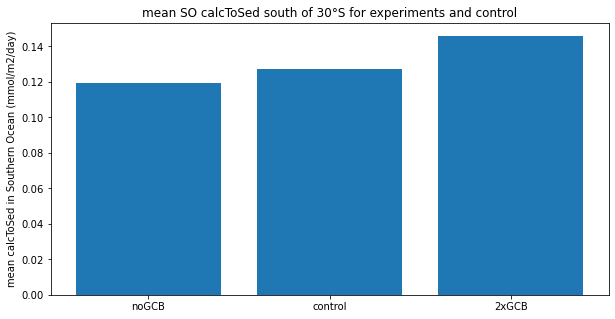

In [35]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_title('mean SO calcToSed south of 30°S for experiments and control')
plt.ylabel('mean calcToSed in Southern Ocean (mmol/m2/day)')
ax.bar(positions,calc2seds)
plt.xticks(positions, labels);

In [28]:
diff_noGCB = cesm_ann_ds.calcToSed_noGCB - cesm_ann_ds.calcToSed
diff_noGCB = diff_noGCB * convert * 365.

In [29]:
diff_2xGCB = cesm_ann_ds.calcToSed_2xGCB - cesm_ann_ds.calcToSed
diff_2xGCB = diff_2xGCB * convert * 365.

In [36]:
control = cesm_ann_ds.calcToSed * convert * 365.

In [46]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

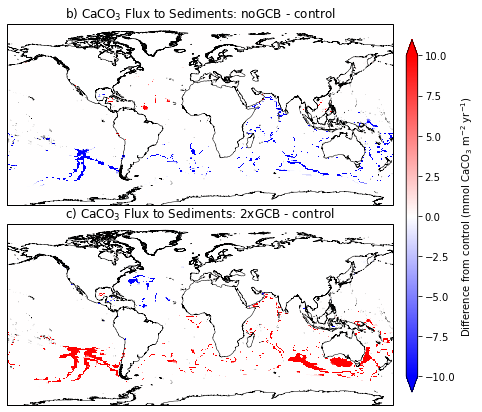

In [47]:
fig = plt.figure(figsize=(8,7))

#---- noGCB diff
lon,lat,field=adjust_pop_grid(lons, lats, diff_noGCB)
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('b) CaCO$_3$ Flux to Sediments: noGCB - control', fontsize=12)
pc1=ax.pcolormesh(lon,lat,field, vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
#---- 2xGCB 
lon,lat,field=adjust_pop_grid(lons, lats, diff_2xGCB)
ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('c) CaCO$_3$ Flux to Sediments: 2xGCB - control', fontsize=12)
pc1=ax.pcolormesh(lon,lat,field, vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc1, cax=cbar_ax,label='Difference from control (mmol CaCO$_3$ m$^{-2}$ yr$^{-1}$)',extend='both')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/caco3_burial_diffs.png',dpi=600, bbox_inches='tight',format='png');


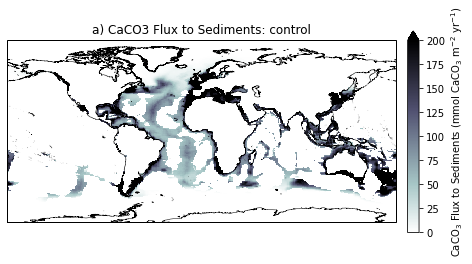

In [48]:
fig = plt.figure(figsize=(8,4))

#---- caco3 to sediment
lon,lat,field=adjust_pop_grid(lons, lats, control)
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) CaCO3 Flux to Sediments: control', fontsize=12)
pc1=ax.pcolormesh(lon, lat,field, vmin=0, vmax=200, cmap='bone_r',
                 transform=ccrs.PlateCarree())


fig.subplots_adjust(right=0.8,hspace=0.1,wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc1, cax=cbar_ax,label='CaCO$_3$ Flux to Sediments (mmol CaCO$_3$ m$^{-2}$ yr$^{-1}$)',extend='max')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/caco3_burial.png',dpi=600, bbox_inches='tight',format='png');
